In [4]:
import opendatasets as od

od.download('https://www.kaggle.com/jsphyg/weather-dataset-rattle-package')

Skipping, found downloaded files in ".\weather-dataset-rattle-package" (use force=True to force download)


In [5]:
import os

os.listdir('.\weather-dataset-rattle-package')

['weatherAUS.csv']

In [119]:
path='.\weather-dataset-rattle-package/weatherAUS.csv'

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib
%matplotlib inline

In [121]:
sns.set_style('darkgrid')
matplotlib.rcParams['font.size']=16
matplotlib.rcParams['figure.figsize']=(10,10)

In [122]:
raw_df=pd.read_csv(path)

In [123]:
pd.set_option('display.max_column',None)
raw_df.Location.head(15000).unique()

array(['Albury', 'BadgerysCreek', 'Cobar', 'CoffsHarbour', 'Moree'],
      dtype=object)

In [124]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [125]:
raw_df.dropna(subset=['RainTomorrow'], inplace=True)

c:\users\swaro\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


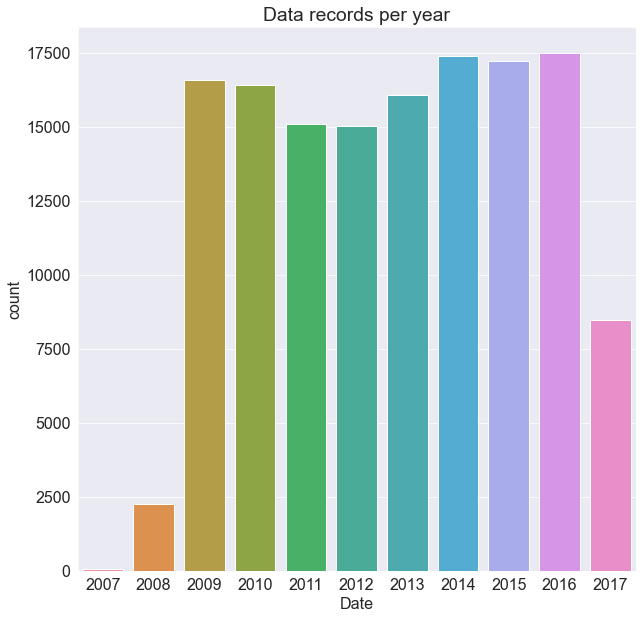

In [126]:
plt.title('Data records per year')
year=pd.to_datetime(raw_df['Date']).dt.year
#plt.figure(figsize=(10,5))
sns.countplot(year);

In [127]:
### splitting data in train validation and test based on time

train_df=raw_df[year<2015]
val_df=raw_df[year==2015]
test_df=raw_df[year>2015]

In [128]:
## dividing input and output columns 
input_cols=list(train_df[1:-1].columns)
target_col='RainTomorrow'

In [129]:
train_df.shape, val_df.shape, test_df.shape

((98988, 23), (17231, 23), (25974, 23))

In [130]:
 
train_input=train_df.iloc[:,1:-1].copy()
train_target=train_df[target_col].copy()

In [131]:
val_input=val_df[input_cols].copy()
val_target=val_df[target_col].copy()

In [132]:
test_input=test_df[input_cols].copy()
test_target=test_df[target_col].copy()

In [133]:
type(test_target)

pandas.core.series.Series

In [134]:
numeric_cols=train_input.select_dtypes(include=np.number).columns.tolist()
cat_cols=train_input.select_dtypes('object').columns.tolist()

In [135]:
print("\033[1m Numeric columns--->>",numeric_cols,"\n categorical columns--->>", cat_cols)

 Numeric columns--->> ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm'] 
 categorical columns--->> ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']


### imputing/ fill nan values with statistical value of the column
***lets impute...

In [136]:
from sklearn.impute import SimpleImputer

In [137]:
imputer=SimpleImputer(strategy='mean')
imputer.fit(raw_df[numeric_cols])

SimpleImputer()

In [138]:
imputer.statistics_

array([  12.18639973,   23.22678419,    2.34997407,    5.46982422,
          7.62485311,   39.98429166,   14.001988  ,   18.63757586,
         68.84381031,   51.48260609, 1017.65375842, 1015.25820354,
          4.43718939,    4.5031669 ,   16.98750858,   21.68723497])

In [139]:
train_input[numeric_cols]=imputer.transform(train_input[numeric_cols])
val_input[numeric_cols]=imputer.transform(val_input[numeric_cols])
test_input[numeric_cols]=imputer.transform(test_input[numeric_cols])

In [140]:
train_input[numeric_cols].isna().sum()

MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
dtype: int64

## scaling numeric columns 
**Here we standardize the each value of each column where in their SD will be 1 and mean will be 0**<br>
**THis is done to avoid the decomp0sition while dealing with loss function <br>
**And also restriction of optimizer is avoided**

In [141]:
from sklearn.preprocessing import MinMaxScaler

In [142]:
scaler=MinMaxScaler().fit(raw_df[numeric_cols])

In [143]:
train_input[numeric_cols]=scaler.transform(train_input[numeric_cols])

In [146]:
val_input[numeric_cols]=scaler.transform(val_input[numeric_cols])
test_input[numeric_cols]=scaler.transform(test_input[numeric_cols])

### one hot encoding categorical column and also getting the feature names for the columns which are encoded

In [149]:
from sklearn.preprocessing import OneHotEncoder

In [168]:

encoder=OneHotEncoder(sparse=False, handle_unknown='ignore').fit(raw_df[cat_cols].fillna('unkown'))

In [169]:
encode_cols=list(encoder.get_feature_names(cat_cols))

In [173]:
test_input[cat_cols]=test_input[cat_cols].fillna('unkown')
test_input[encode_cols]=encoder.transform(test_input[cat_cols])

In [174]:
train_input[cat_cols]=train_input[cat_cols].fillna('unkown')
train_input[encode_cols]=encoder.transform(train_input[cat_cols])

val_input[encode_cols]=encoder.transform(val_input[cat_cols].fillna('unknown'))

#### Everthing is done lets separate out the input columns  

In [175]:
x_train=train_input[numeric_cols+encode_cols]
x_val=val_input[numeric_cols+encode_cols]
x_test=test_input[numeric_cols+encode_cols]

In [176]:
x_train.head(100)

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,Location_Adelaide,Location_Albany,Location_Albury,Location_AliceSprings,Location_BadgerysCreek,Location_Ballarat,Location_Bendigo,Location_Brisbane,Location_Cairns,Location_Canberra,Location_Cobar,Location_CoffsHarbour,Location_Dartmoor,Location_Darwin,Location_GoldCoast,Location_Hobart,Location_Katherine,Location_Launceston,Location_Melbourne,Location_MelbourneAirport,Location_Mildura,Location_Moree,Location_MountGambier,Location_MountGinini,Location_Newcastle,Location_Nhil,Location_NorahHead,Location_NorfolkIsland,Location_Nuriootpa,Location_PearceRAAF,Location_Penrith,Location_Perth,Location_PerthAirport,Location_Portland,Location_Richmond,Location_Sale,Location_SalmonGums,Location_Sydney,Location_SydneyAirport,Location_Townsville,Location_Tuggeranong,Location_Uluru,Location_WaggaWagga,Location_Walpole,Location_Watsonia,Location_Williamtown,Location_Witchcliffe,Location_Wollongong,Location_Woomera,WindGustDir_E,WindGustDir_ENE,WindGustDir_ESE,WindGustDir_N,WindGustDir_NE,WindGustDir_NNE,WindGustDir_NNW,WindGustDir_NW,WindGustDir_S,WindGustDir_SE,WindGustDir_SSE,WindGustDir_SSW,WindGustDir_SW,WindGustDir_W,WindGustDir_WNW,WindGustDir_WSW,WindGustDir_unkown,WindDir9am_E,WindDir9am_ENE,WindDir9am_ESE,WindDir9am_N,WindDir9am_NE,WindDir9am_NNE,WindDir9am_NNW,WindDir9am_NW,WindDir9am_S,WindDir9am_SE,WindDir9am_SSE,WindDir9am_SSW,WindDir9am_SW,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW,WindDir9am_unkown,WindDir3pm_E,WindDir3pm_ENE,WindDir3pm_ESE,WindDir3pm_N,WindDir3pm_NE,WindDir3pm_NNE,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,WindDir3pm_unkown,RainToday_No,RainToday_Yes,RainToday_unkown
0,0.516509,0.523629,0.001617,0.037723,0.525852,0.294574,0.153846,0.275862,0.71,0.22,0.449587,0.4800,0.888889,0.500352,0.508439,0.522073,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.375000,0.565217,0.000000,0.037723,0.525852,0.294574,0.030769,0.252874,0.44,0.25,0.497521,0.4912,0.493021,0.500352,0.514768,0.570058,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.504717,0.576560,0.000000,0.037723,0.525852,0.310078,0.146154,0.298851,0.38,0.30,0.447934,0.5056,0.493021,0.222222,0.594937,0.548944,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,0.417453,0.620038,0.000000,0.037723,0.525852,0.139535,0.084615,0.103448,0.45,0.16,0.613223,0.5712,0.493021,0.500352,0.533755,0.612284,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.

#### lets train the model (using DecisionTreeClassifier from sklearn.tree)

In [177]:
from sklearn.tree import DecisionTreeClassifier

In [235]:
model=DecisionTreeClassifier(random_state=42)

In [246]:
%%time

model.fit(x_train,train_target)

Wall time: 2.95 s


DecisionTreeClassifier(random_state=42)

In [247]:
prediction=model.predict(x_train)

In [248]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [260]:
accuracy_score(train_target, prediction)

0.9999797955307714

In [262]:
cf=confusion_matrix(train_target,prediction)

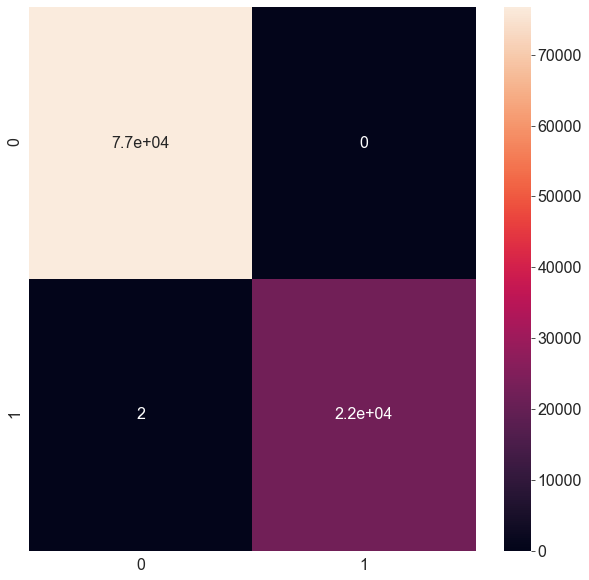

In [271]:
sns.heatmap(data=cf, annot=True);

In [265]:
?sns.heatmap

In [250]:
## probabilistic view
prob=model.predict_proba(x_train)

In [251]:
pd.value_counts(prediction)

No     76707
Yes    22281
dtype: int64

In [258]:
## lets check on validation and test data set


print('\033[1m test_accuracy:',model.score(x_test, test_target),"\n validation accuracy",model.score(x_val,val_target))

 test_accuracy: 0.7623007623007623 
 validation accuracy 0.24751900644187802


In [244]:
?DecisionTreeClassifier

In [208]:
val_target.value_counts()/len(val_target)

No     0.788289
Yes    0.211711
Name: RainTomorrow, dtype: float64

In [226]:
x_train.shape,x_val.shape,x_test.shape

((98988, 119), (17231, 119), (25974, 119))

##### model is overfitted  here, hence we need to handle it by pruning it. before that we nee to visualize the tree 

In [227]:
from sklearn.tree import plot_tree, export_text

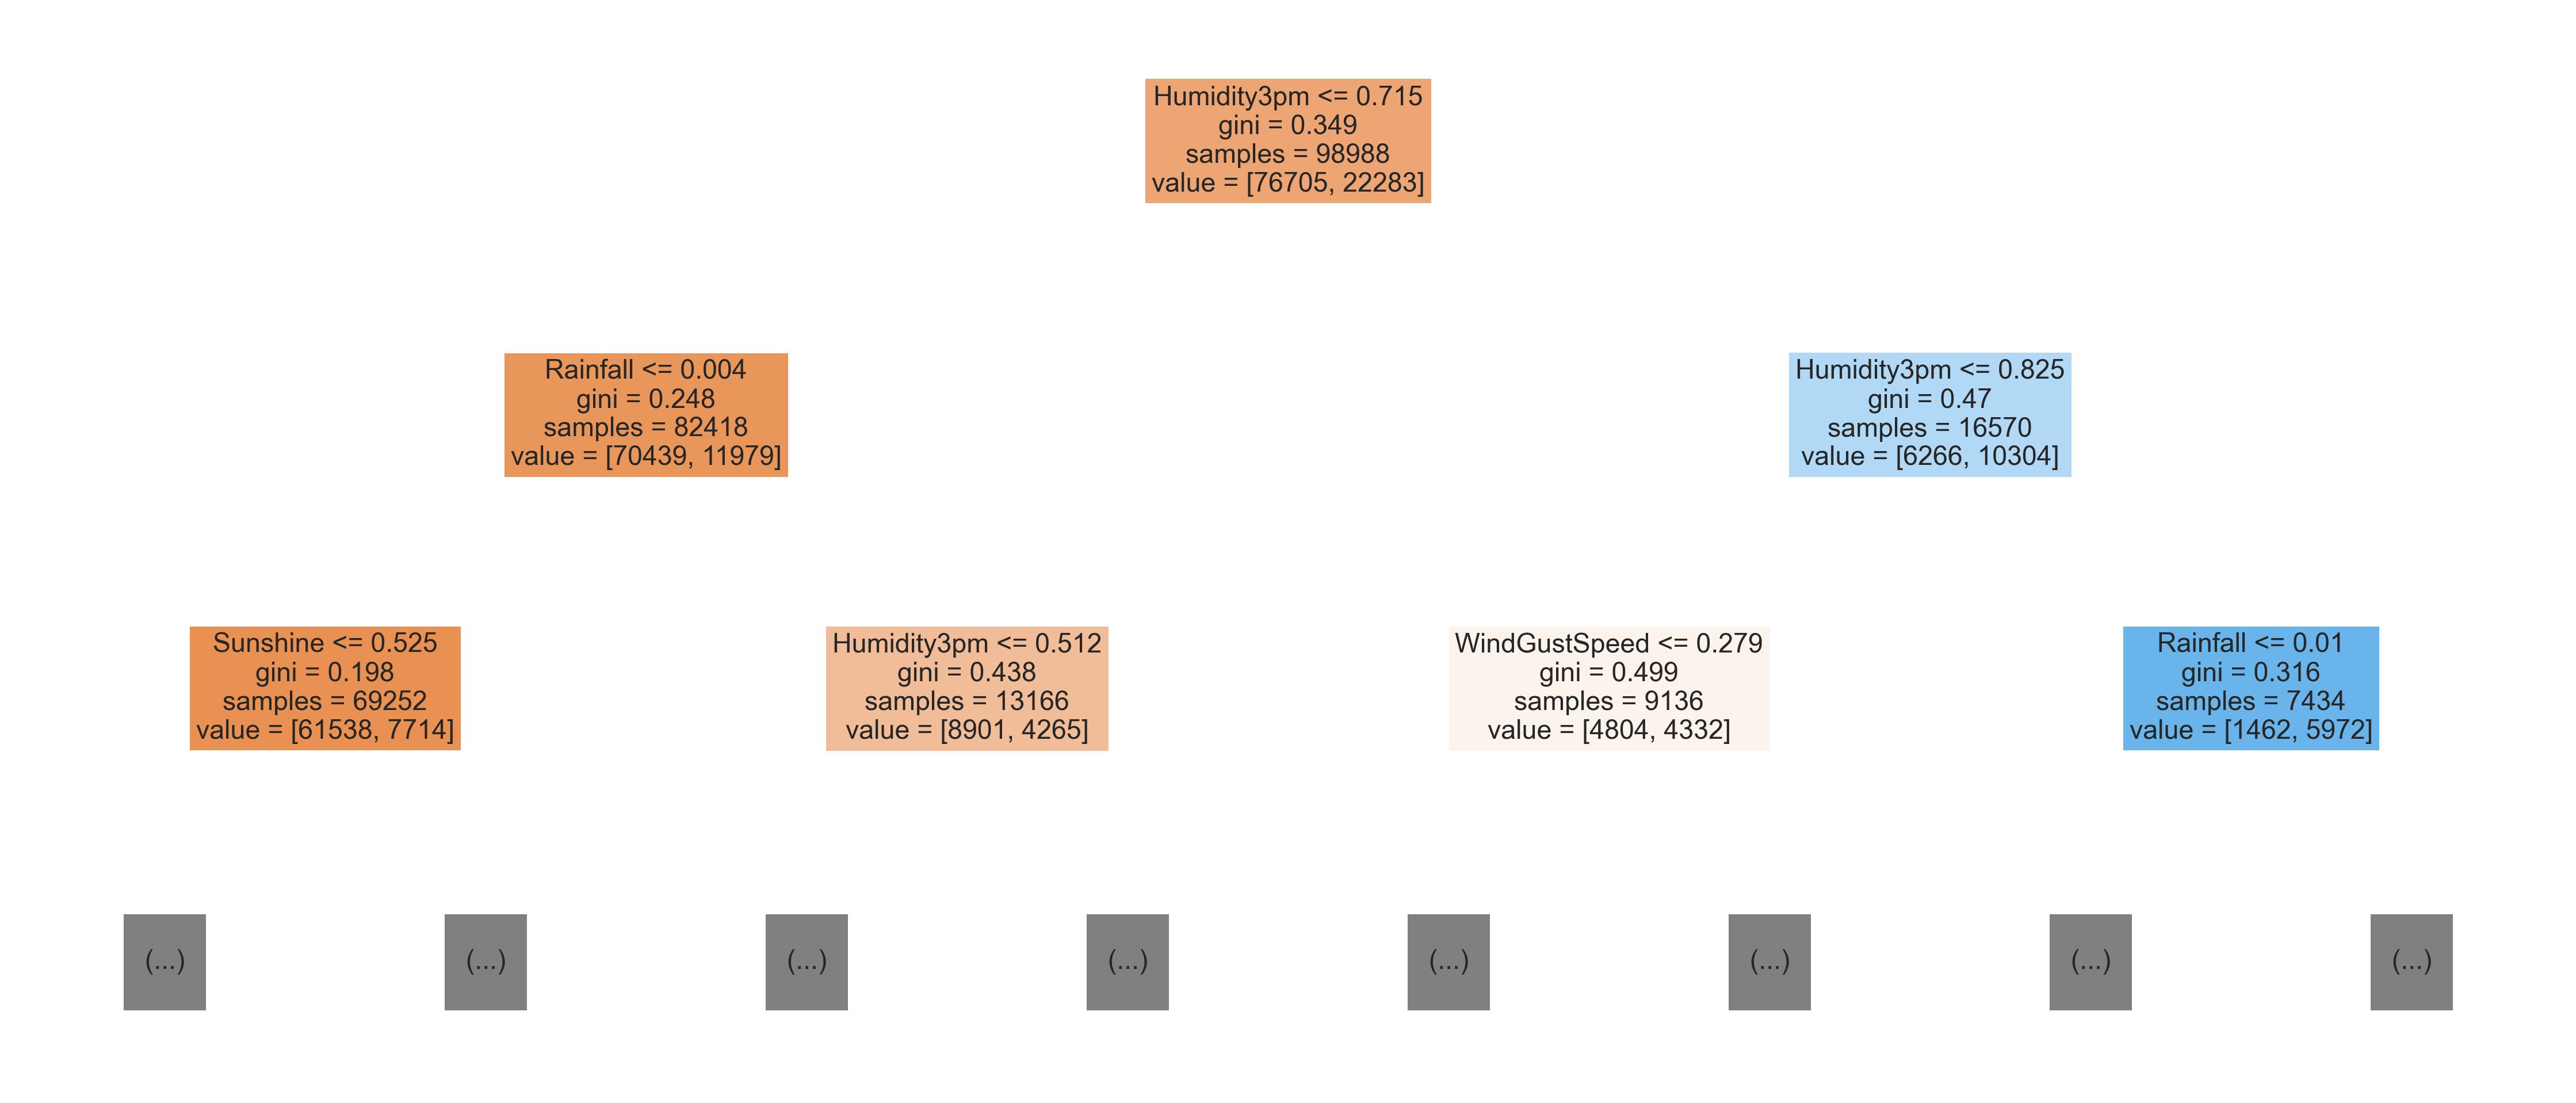

In [228]:
plt.figure(figsize=(80,35))
plot_tree(model, feature_names=x_train.columns,max_depth=2, filled=True);

**Model accuracy with train data is 99% which is almost hundred but on validation dataset it less than the base line models*<b>
    
**GINI INDEX........ 
    split with 0 gini index is said to be perfect split<br>
    If the gini index is less then the split is better and the contrary is also true
$$ I_{{g}} = 1 - \sum \limits _{j=1}^{n} p^{2}_{j} $$    
    

In [255]:
## visualizing the tree using export text method
model_text=export_text(model,feature_names=list(x_train.columns), max_depth=10)
print(model_text)


|--- Humidity3pm <= 0.72
|   |--- Rainfall <= 0.00
|   |   |--- Sunshine <= 0.52
|   |   |   |--- Pressure3pm <= 0.58
|   |   |   |   |--- WindGustSpeed <= 0.36
|   |   |   |   |   |--- Humidity3pm <= 0.28
|   |   |   |   |   |   |--- WindDir9am_NE <= 0.50
|   |   |   |   |   |   |   |--- Location_Watsonia <= 0.50
|   |   |   |   |   |   |   |   |--- Cloud9am <= 0.83
|   |   |   |   |   |   |   |   |   |--- WindSpeed3pm <= 0.07
|   |   |   |   |   |   |   |   |   |   |--- Pressure3pm <= 0.46
|   |   |   |   |   |   |   |   |   |   |   |--- class: Yes
|   |   |   |   |   |   |   |   |   |   |--- Pressure3pm >  0.46
|   |   |   |   |   |   |   |   |   |   |   |--- class: No
|   |   |   |   |   |   |   |   |   |--- WindSpeed3pm >  0.07
|   |   |   |   |   |   |   |   |   |   |--- MinTemp <= 0.32
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |   |--- MinTemp >  0.32
|   |   |   |   |   |   |   |   |   |   |   |--- truncated

In [253]:
model.tree_.max_depth

48

 #### Lets look into the error with respect model complexity(model depth)
 **Hyperparameter tuning--->> choosing the right hyperparameters to the model so that it can work well

In [282]:
def model_err(md):
    model=DecisionTreeClassifier(max_depth=md, random_state=43)
    model.fit(x_train,train_target)
    train_acc=model.score(x_train, train_target)
    val_acc=model.score(x_val, val_target)
    train_err=1-train_acc
    val_err=1-val_acc
    return {'model_depth': md, 'train_err':train_err,'val_err':val_err,'train_acc':train_acc,'val_acc':val_acc}

In [284]:
%%time
EMd_df=pd.DataFrame(model_err(md) for md in range(1,25))

Wall time: 47.7 s


In [285]:
EMd_df

,model_depth,train_err,val_err,train_acc,val_acc
0,1,0.184315,0.211711,0.815685,0.788289
1,2,0.179547,0.211711,0.820453,0.788289
2,3,0.170869,0.211711,0.829131,0.788289
3,4,0.165707,0.211711,0.834293,0.788289
4,5,0.160676,0.211711,0.839324,0.788289
5,6,0.156271,0.211711,0.843729,0.788289
6,7,0.153312,0.211711,0.846688,0.788289
7,8,0.147806,0.222158,0.852194,0.777842
8,9,0.140916,0.222158,0.859084,0.777842
9,10,0.132986,0.222158,0.867014,0.777842


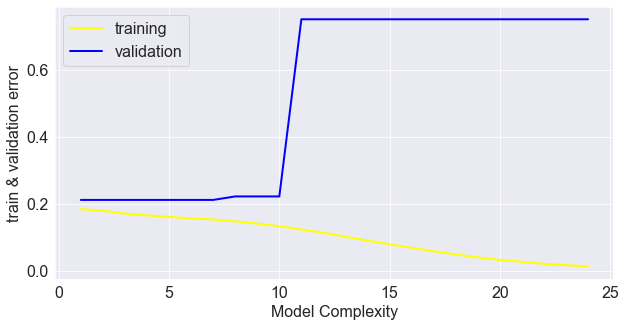

In [306]:
plt.figure(figsize=(10,5))
plt.plot(EMd_df['model_depth'], EMd_df['train_err'], color='yellow',linewidth=2)
plt.plot(EMd_df['model_depth'], EMd_df['val_err'], color='blue',linewidth=2)
plt.xlabel('Model Complexity')
plt.ylabel('train & validation error')
plt.legend(['training','validation'])

##### In reference  to the graph above we can infer that the point at which both validation and train datasets errors meet is considered as ideal one to forge our model. Because that is the only point at which model errors of both train and validation dataset is minimum.

**Best fit point<br>


In [313]:
## lets train our model by providing model complexity of 10
model=DecisionTreeClassifier(max_depth=9, random_state=42)
model.fit(x_train,train_target)

print('train_accuracy',model.score(x_train,train_target))
print('val_accuracy:', model.score(x_val, val_target))

train_accuracy 0.8590940315997899
val_accuracy: 0.7778422610411467


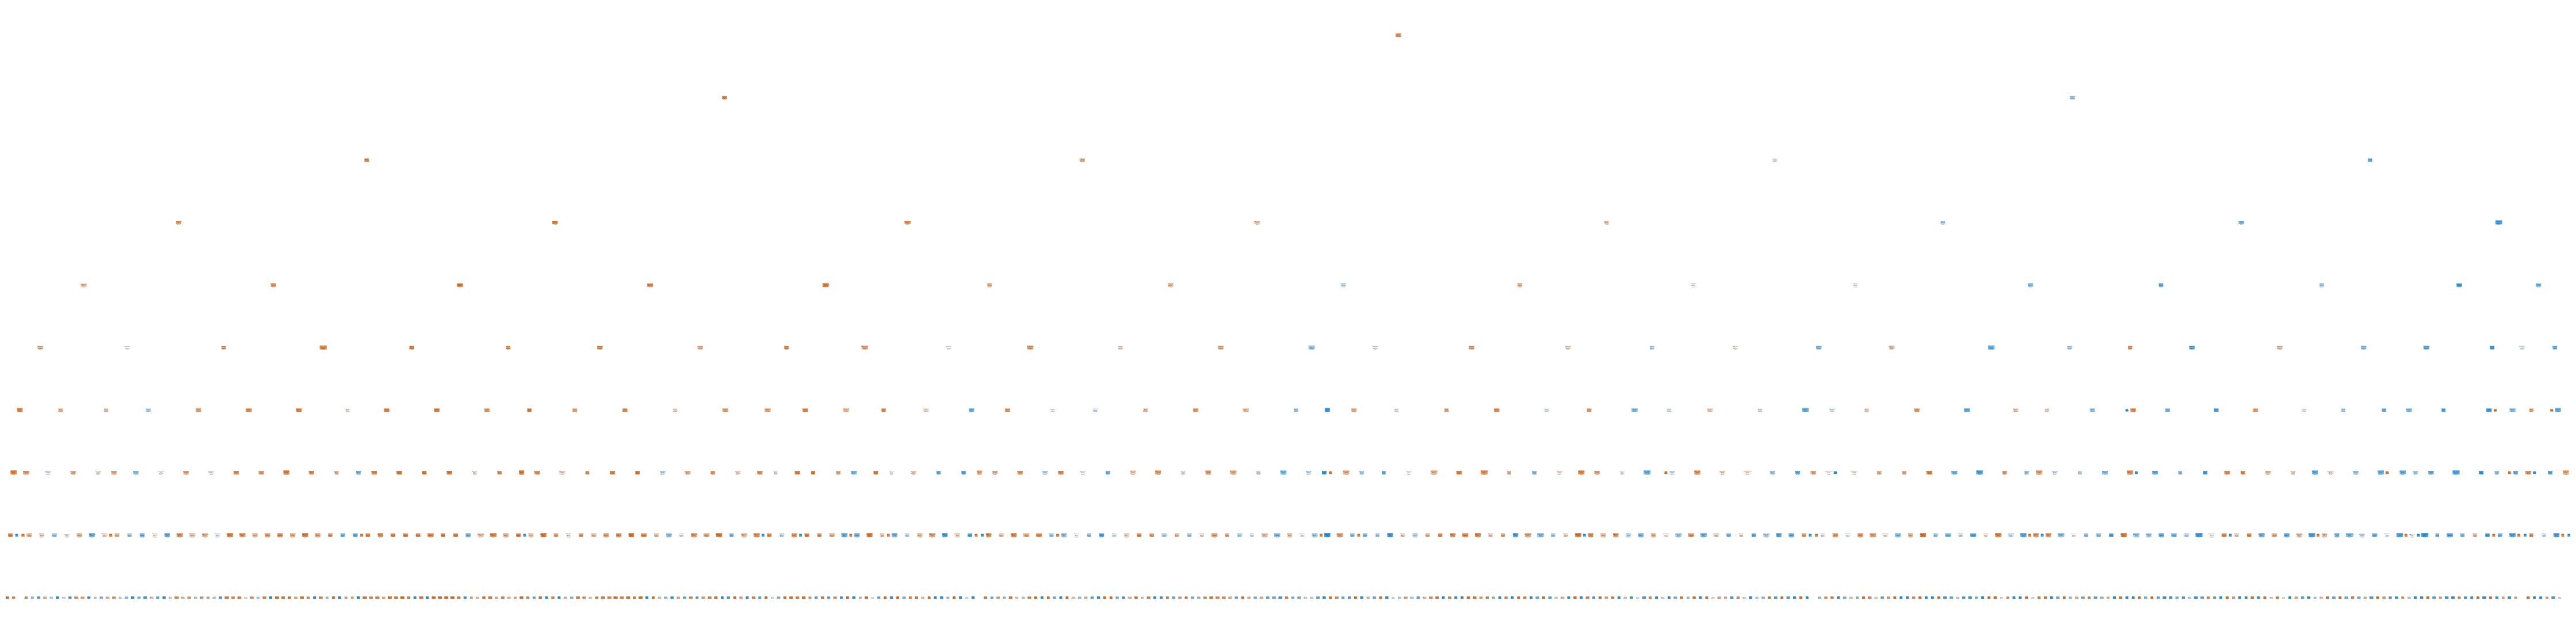

In [314]:
from sklearn.tree import plot_tree, export_text
plt.figure(figsize=(80,20))
plot_tree(model, feature_names=x_train.columns, filled=True, rounded=True, class_names=model.classes_);

In [291]:
?plot_tree

In [300]:
text_tree=export_text(model, feature_names=list(x_train.columns), max_depth=10)
print(text_tree)

|--- Humidity3pm <= 0.72
|   |--- Rainfall <= 0.00
|   |   |--- Sunshine <= 0.52
|   |   |   |--- Pressure3pm <= 0.58
|   |   |   |   |--- WindGustSpeed <= 0.36
|   |   |   |   |   |--- Humidity3pm <= 0.28
|   |   |   |   |   |   |--- WindDir9am_NE <= 0.50
|   |   |   |   |   |   |   |--- Location_Watsonia <= 0.50
|   |   |   |   |   |   |   |   |--- Cloud9am <= 0.83
|   |   |   |   |   |   |   |   |   |--- WindSpeed3pm <= 0.07
|   |   |   |   |   |   |   |   |   |   |--- class: No
|   |   |   |   |   |   |   |   |   |--- WindSpeed3pm >  0.07
|   |   |   |   |   |   |   |   |   |   |--- class: No
|   |   |   |   |   |   |   |   |--- Cloud9am >  0.83
|   |   |   |   |   |   |   |   |   |--- Rainfall <= 0.00
|   |   |   |   |   |   |   |   |   |   |--- class: No
|   |   |   |   |   |   |   |   |   |--- Rainfall >  0.00
|   |   |   |   |   |   |   |   |   |   |--- class: Yes
|   |   |   |   |   |   |   |--- Location_Watsonia >  0.50
|   |   |   |   |   |   |   |   |--- class: Yes
|   |   

#### Another method to reduce overfitting and unerfitting is pruning/ Max_leaf_node
**by controlling the number of leaf node, complexity of the model is optimized. This allows branches of the tree to have varying  depth**  

In [316]:
from sklearn.tree import DecisionTreeClassifier

In [323]:
model=DecisionTreeClassifier(max_leaf_nodes=125, random_state=42)
model.fit(x_train,train_target)

DecisionTreeClassifier(max_leaf_nodes=125, random_state=42)

In [324]:
print("\033[1mtrain accuracy ",model.score(x_train, train_target))
print("validation accuracy \033[1m",model.score(x_val, val_target))

train accuracy  0.8478906534125349
validation accuracy  0.7882885497069235


In [327]:
tree_test=export_text(model, feature_names=list(x_train.columns),max_depth=10)
print(tree_test)

|--- Humidity3pm <= 0.72
|   |--- Rainfall <= 0.00
|   |   |--- Sunshine <= 0.52
|   |   |   |--- Pressure3pm <= 0.58
|   |   |   |   |--- WindGustSpeed <= 0.36
|   |   |   |   |   |--- Humidity3pm <= 0.28
|   |   |   |   |   |   |--- class: No
|   |   |   |   |   |--- Humidity3pm >  0.28
|   |   |   |   |   |   |--- Sunshine <= 0.05
|   |   |   |   |   |   |   |--- class: Yes
|   |   |   |   |   |   |--- Sunshine >  0.05
|   |   |   |   |   |   |   |--- Pressure3pm <= 0.43
|   |   |   |   |   |   |   |   |--- class: Yes
|   |   |   |   |   |   |   |--- Pressure3pm >  0.43
|   |   |   |   |   |   |   |   |--- Humidity3pm <= 0.57
|   |   |   |   |   |   |   |   |   |--- WindDir9am_NE <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- WindDir9am_NNE <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: No
|   |   |   |   |   |   |   |   |   |   |--- WindDir9am_NNE >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: No
|   |   |   |   |   |   |   |   |   |--- WindD

## END